In [2]:
import warnings
warnings.filterwarnings('ignore')

import koreanize_matplotlib

# 모델 학습

In [24]:
import pandas as pd

# 저장
train = pd.read_csv('Data/train_0809.csv')


In [77]:
test = pd.read_csv('Data/test_0809.csv')

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   건물유형               204000 non-null  object 
 1   건물번호               204000 non-null  int64  
 2   기온(°C)             204000 non-null  float64
 3   강수량(mm)            204000 non-null  float64
 4   풍속(m/s)            204000 non-null  float64
 5   습도(%)              204000 non-null  float64
 6   일조(hr)             204000 non-null  float64
 7   일사(MJ/m2)          204000 non-null  float64
 8   전력소비량(kWh)         204000 non-null  float64
 9   연면적(m2)            204000 non-null  float64
 10  냉방면적(m2)           204000 non-null  float64
 11  태양광용량(kW)          204000 non-null  float64
 12  ESS저장용량(kWh)       204000 non-null  float64
 13  PCS용량(kW)          204000 non-null  float64
 14  일시                 204000 non-null  object 
 15  월                  204000 non-null  int64  
 16  일 

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822400 entries, 0 to 2822399
Data columns (total 33 columns):
 #   Column             Dtype  
---  ------             -----  
 0   건물유형               object 
 1   건물번호               int64  
 2   기온(°C)             float64
 3   강수량(mm)            float64
 4   풍속(m/s)            float64
 5   습도(%)              float64
 6   일조(hr)             int64  
 7   일사(MJ/m2)          int64  
 8   연면적(m2)            float64
 9   냉방면적(m2)           float64
 10  태양광용량(kW)          float64
 11  ESS저장용량(kWh)       float64
 12  PCS용량(kW)          float64
 13  일시                 object 
 14  월                  int64  
 15  일                  int64  
 16  요일                 int64  
 17  시간                 int64  
 18  월_sin              float64
 19  월_cos              float64
 20  요일_sin             float64
 21  요일_cos             float64
 22  시간_sin             float64
 23  시간_cos             float64
 24  일_sin              float64
 25  일_cos             

In [25]:
test_X =  test.drop(['건물유형','일시'], axis = 1)

In [35]:
X = train[test_X.columns]
Y = train[['건물번호', '전력소비량(kWh)']]

In [36]:
import numpy as np

def smape(gt, preds):
    gt = np.array(gt)
    preds = np.array(preds)
    v = 2 * abs(preds - gt) / (abs(preds) + abs(gt))
    score = np.mean(v) * 100
    return score

def weighted_mse(alpha=1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual > 0, -2 * alpha * residual, -2 * residual)
        hess = np.where(residual > 0,  2 * alpha,               2.0)
        return grad, hess
    return weighted_mse_fixed

def custom_smape(preds, dtrain):
    labels = dtrain.get_label()
    return 'custom_smape', np.mean(2 * abs(preds - labels) / (abs(preds) + abs(labels))) * 100


In [37]:
from sklearn.model_selection import KFold

RANDOM_SEED   = 42
KFOLD_SPLITS  = 7

bnum_list = X["건물번호"].unique()

# 결과 담을 DF
answer_df = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
pred_df   = pd.DataFrame(index=X.index,       columns=["pred"],   dtype=float)

kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=RANDOM_SEED)

In [47]:
from xgboost import XGBRegressor

global_model = XGBRegressor(
    learning_rate=0.05, n_estimators=2000, max_depth=8,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=3,
    random_state=RANDOM_SEED, objective=weighted_mse(3),
    tree_method="hist"
)

# 전역 모델 학습 (건물번호/건물유형 제외한 X와 log-타깃)
global_model.fit(
    X.drop(columns=['건물번호','건물유형'], errors='ignore'),
    np.log(Y['전력소비량(kWh)'].clip(lower=1e-6))
)

for bnum in bnum_list:
    x  = X  [X['건물번호'] == bnum].copy()
    y  = Y  [Y['건물번호'] == bnum]['전력소비량(kWh)'].copy()
    xt = test_X[test_X['건물번호'] == bnum].copy()

    drop_cols = ['건물번호']
    if '건물유형' in x.columns:
        drop_cols.append('건물유형')
    x  = x .drop(columns=drop_cols, errors='ignore')
    xt = xt.drop(columns=drop_cols, errors='ignore')

    preds_valid = pd.Series(index=y.index, dtype=float)
    preds_test  = []

    x_values = x.values
    y_values = y.values

    if len(x) < KFOLD_SPLITS:
        preds_valid[:] = np.exp(global_model.predict(x))
        if len(xt):
            answer_df.loc[xt.index, 'answer'] = np.exp(global_model.predict(xt))
        pred_df.loc[preds_valid.index, 'pred'] = preds_valid
        print(f'건물번호 {bnum}: 표본 {len(x)}개 → 전역 모델 사용')
        continue

    fold_scores = []
    for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values), 1):
        X_tr, X_va = x_values[tr_idx], x_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]

        y_tr_log = np.log(np.maximum(y_tr, 1e-6))
        y_va_log = np.log(np.maximum(y_va, 1e-6))

        model = XGBRegressor(
            learning_rate=0.05,
            n_estimators=5000,
            max_depth=10,
            subsample=0.7,
            colsample_bytree=0.5,
            min_child_weight=3,
            random_state=RANDOM_SEED,
            objective=weighted_mse(3),
            eval_metric='rmse',
            tree_method='hist'
        )

        # ▼ 변경: eval_metric = 'rmse' (내장 지표), early_stopping_rounds는 fit에 전달
        model.fit(
            X_tr, y_tr_log,
            eval_set=[(X_va, y_va_log)],
            #early_stopping_rounds=100,
            verbose=False,
        )

        va_pred = np.exp(model.predict(X_va))
        preds_valid.iloc[va_idx] = va_pred

        fold_smape = smape(y_va, va_pred)  # 최종 평가는 SMAPE
        fold_scores.append(fold_smape)

        if len(xt):
            preds_test.append(np.exp(model.predict(xt.values)))

    pred_df.loc[preds_valid.index, 'pred'] = preds_valid
    if len(xt):
        answer_df.loc[xt.index, 'answer'] = np.mean(preds_test, axis=0)

    print(f'건물번호 {bnum} : XGB SMAPE = {np.mean(fold_scores):.4f}')


건물번호 1 : XGB SMAPE = 7.2685
건물번호 2 : XGB SMAPE = 4.8112
건물번호 3 : XGB SMAPE = 2.3457
건물번호 4 : XGB SMAPE = 4.6651
건물번호 5 : XGB SMAPE = 1.6504
건물번호 6 : XGB SMAPE = 6.4339
건물번호 7 : XGB SMAPE = 11.3631
건물번호 8 : XGB SMAPE = 6.8329
건물번호 9 : XGB SMAPE = 5.4314
건물번호 10 : XGB SMAPE = 7.0573
건물번호 11 : XGB SMAPE = 4.1518
건물번호 12 : XGB SMAPE = 2.1125
건물번호 13 : XGB SMAPE = 3.2660
건물번호 14 : XGB SMAPE = 2.3471
건물번호 15 : XGB SMAPE = 3.3817
건물번호 16 : XGB SMAPE = 2.1201
건물번호 17 : XGB SMAPE = 13.7553
건물번호 18 : XGB SMAPE = 3.7595
건물번호 19 : XGB SMAPE = 6.3522
건물번호 20 : XGB SMAPE = 0.8854
건물번호 21 : XGB SMAPE = 1.7210
건물번호 22 : XGB SMAPE = 2.7578
건물번호 23 : XGB SMAPE = 8.0620
건물번호 24 : XGB SMAPE = 4.3820
건물번호 25 : XGB SMAPE = 10.0440
건물번호 26 : XGB SMAPE = 7.7731
건물번호 27 : XGB SMAPE = 4.9611
건물번호 28 : XGB SMAPE = 3.7414
건물번호 29 : XGB SMAPE = 8.1928
건물번호 30 : XGB SMAPE = 0.5685
건물번호 31 : XGB SMAPE = 3.4450
건물번호 32 : XGB SMAPE = 5.2118
건물번호 33 : XGB SMAPE = 8.0523
건물번호 34 : XGB SMAPE = 2.5513
건물번호 35 : XGB SMAPE 

In [48]:
# 전체 SMAPE 계산
total_smape = smape(
    Y.sort_index()["전력소비량(kWh)"].values,
    pred_df.sort_index()["pred"].values
)
print(f"Total SMAPE = {total_smape:.4f}")

Total SMAPE = 4.5264


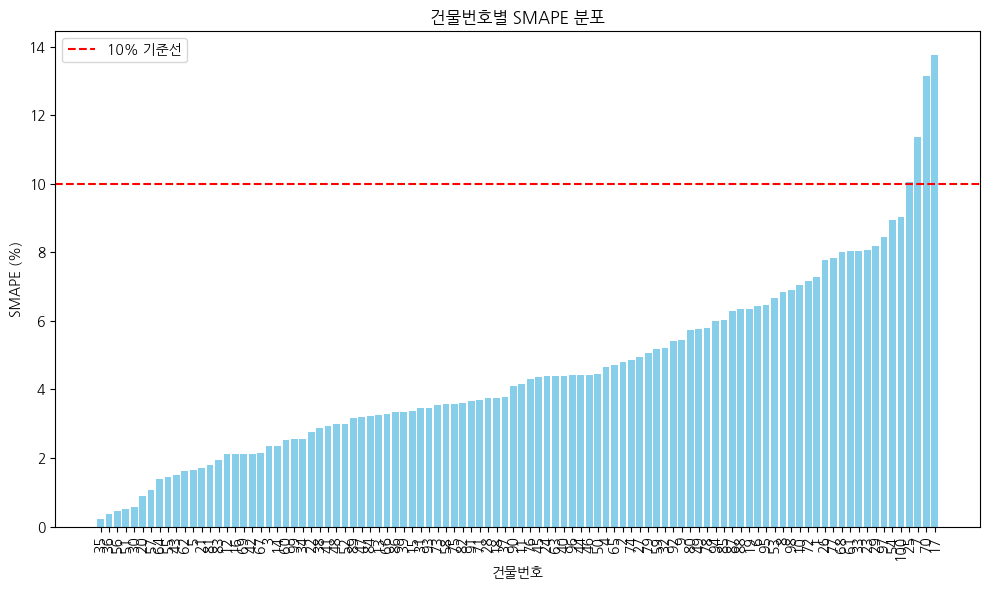

전체 건물 평균 SMAPE: 4.5264%
성능 좋은 건물 (<10% SMAPE) 개수: 96 / 100


In [76]:
import matplotlib.pyplot as plt

# 건물번호별 SMAPE 계산
bnum_smapes = []

for bnum in Y['건물번호'].unique():
    gt   = Y[Y['건물번호'] == bnum]['전력소비량(kWh)'].values
    pred = pred_df.loc[Y[Y['건물번호'] == bnum].index, 'pred'].values
    bnum_smape = smape(gt, pred)
    bnum_smapes.append((bnum, bnum_smape))

bnum_smapes_df = pd.DataFrame(bnum_smapes, columns=['건물번호', 'SMAPE']).sort_values('SMAPE')

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(bnum_smapes_df['건물번호'].astype(str), bnum_smapes_df['SMAPE'], color='skyblue')
plt.axhline(10, color='red', linestyle='--', label='10% 기준선')
plt.xticks(rotation=90)
plt.xlabel('건물번호')
plt.ylabel('SMAPE (%)')
plt.title('건물번호별 SMAPE 분포')
plt.legend()
plt.tight_layout()
plt.show()

# 성능 요약 출력
print(f"전체 건물 평균 SMAPE: {bnum_smapes_df['SMAPE'].mean():.4f}%")
print(f"성능 좋은 건물 (<10% SMAPE) 개수: {(bnum_smapes_df['SMAPE'] < 10).sum()} / {len(bnum_smapes_df)}")


## xgboost.train(), DMatrix

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb

# --- 전제: 아래 3개 함수가 이미 정의되어 있어야 함 ---
# smape(gt, preds), weighted_mse(alpha), custom_smape(preds, dtrain)  # (feval은 이번 코드에선 사용하지 않음)

RANDOM_SEED  = 42
KFOLD_SPLITS = 7
TARGET = '전력소비량(kWh)'

# ===== 0) 전역 모델 (fallback) - DMatrix 버전 =====
X_global = X.drop(columns=['건물번호','건물유형'], errors='ignore').values
y_global_log = np.log(np.maximum(Y[TARGET].values, 1e-6))

dtrain_global = xgb.DMatrix(X_global, label=y_global_log)

params_global = {
    'learning_rate': 0.05,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'tree_method': 'hist',
    'seed': RANDOM_SEED,
    'eval_metric': 'rmse',   # 모니터링 지표 (내장)
}
# 전역모델은 홀드아웃 없이 깔끔하게 학습(조기종료 없이)
global_bst = xgb.train(
    params=params_global,
    dtrain=dtrain_global,
    num_boost_round=2000,
    obj=weighted_mse(3),
    verbose_eval=False
)

# ===== 1) 건물번호별 학습/예측 =====
answer_df = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
pred_df   = pd.DataFrame(index=X.index,       columns=["pred"],   dtype=float)

bnum_list = X["건물번호"].unique()

from sklearn.model_selection import KFold
kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=RANDOM_SEED)

for bnum in bnum_list:
    x_df  = X  [X['건물번호'] == bnum].copy()
    y_ser = Y  [Y['건물번호'] == bnum][TARGET].copy()
    xt_df = test_X[test_X['건물번호'] == bnum].copy()

    # 상수/식별자 제거
    drop_cols = ['건물번호']
    if '건물유형' in x_df.columns: drop_cols.append('건물유형')
    x_df  = x_df .drop(columns=drop_cols, errors='ignore')
    xt_df = xt_df.drop(columns=drop_cols, errors='ignore')

    preds_valid = pd.Series(index=y_ser.index, dtype=float)
    preds_test_list = []

    X_mat = x_df.values
    y_arr = y_ser.values

    if len(x_df) < KFOLD_SPLITS:
        # 표본 부족 → 전역 모델 fallback
        dX  = xgb.DMatrix(X_mat)
        preds_valid[:] = np.exp(global_bst.predict(dX))
        if len(xt_df):
            dXt = xgb.DMatrix(xt_df.values)
            answer_df.loc[xt_df.index, "answer"] = np.exp(global_bst.predict(dXt))
        pred_df.loc[preds_valid.index, "pred"] = preds_valid
        print(f'건물번호 {bnum}: 표본 {len(x_df)}개 → 전역 모델 사용')
        continue

    fold_scores = []
    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_mat), 1):
        X_tr, X_va = X_mat[tr_idx], X_mat[va_idx]
        y_tr, y_va = y_arr[tr_idx], y_arr[va_idx]

        # 로그 타깃
        y_tr_log = np.log(np.maximum(y_tr, 1e-6))
        y_va_log = np.log(np.maximum(y_va, 1e-6))

        dtrain = xgb.DMatrix(X_tr, label=y_tr_log)
        dvalid = xgb.DMatrix(X_va, label=y_va_log)

        params = {
            'learning_rate': 0.05,
            'max_depth': 10,
            'subsample': 0.7,
            'colsample_bytree': 0.5,
            'min_child_weight': 3,
            'tree_method': 'hist',
            'seed': RANDOM_SEED,
            'eval_metric': 'rmse',   # 내장 지표로 모니터링
        }

        bst = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=5000,
            evals=[(dvalid, 'valid')],
            obj=weighted_mse(3),        # 커스텀 손실
            # feval=custom_smape,       # ← 원하면 커스텀 평가(표시용)도 함께 사용 가능
            early_stopping_rounds=100,
            verbose_eval=False
        )

        # 검증 예측 (best_iteration까지)
        va_pred_log = bst.predict(dvalid, iteration_range=(0, bst.best_iteration + 1))
        va_pred = np.exp(va_pred_log)
        preds_valid.iloc[va_idx] = va_pred

        # SMAPE로 fold 점수 기록
        fold_scores.append(smape(y_va, va_pred))

        # 테스트 예측
        if len(xt_df):
            dtest = xgb.DMatrix(xt_df.values)
            te_pred_log = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
            preds_test_list.append(np.exp(te_pred_log))

    pred_df.loc[preds_valid.index, "pred"] = preds_valid
    if len(xt_df):
        answer_df.loc[xt_df.index, "answer"] = np.mean(preds_test_list, axis=0)

    print(f'건물번호 {bnum} : XGB SMAPE = {np.mean(fold_scores):.4f}')



In [ ]:
# ===== 2) 전체 SMAPE =====
total_smape = smape(
    Y.sort_index()[TARGET].values,
    pred_df.sort_index()["pred"].values
)
print(f"Total SMAPE = {total_smape:.4f}")


In [53]:
test_X

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822400 entries, 0 to 2822399
Data columns (total 31 columns):
 #   Column             Dtype  
---  ------             -----  
 0   건물번호               int64  
 1   기온(°C)             float64
 2   강수량(mm)            float64
 3   풍속(m/s)            float64
 4   습도(%)              float64
 5   일조(hr)             int64  
 6   일사(MJ/m2)          int64  
 7   연면적(m2)            float64
 8   냉방면적(m2)           float64
 9   태양광용량(kW)          float64
 10  ESS저장용량(kWh)       float64
 11  PCS용량(kW)          float64
 12  월                  int64  
 13  일                  int64  
 14  요일                 int64  
 15  시간                 int64  
 16  월_sin              float64
 17  월_cos              float64
 18  요일_sin             float64
 19  요일_cos             float64
 20  시간_sin             float64
 21  시간_cos             float64
 22  일_sin              float64
 23  일_cos              float64
 24  건물유형_max           float64
 25  건물유형_mean         

In [ ]:
print("answer_df NA:", answer_df['answer'].isna().sum())
print("test_X 시간 분포:", test_X['시간'].value_counts().sort_index().head(10))
print("예시 1개 건물 시간 샘플:", test_X[test_X['건물번호']==bnum_list[0]]['시간'].unique()[:10])


# 결과


In [ ]:
submission = pd.read_csv('Data/sample_submission.csv')

In [78]:
# ===== 파라미터 =====
YEAR = 2024
MONTH = 8                     # 8월만 사용 (필요시 바꿔줘)
BUILDINGS = list(range(1, 101))
DAYS = list(range(25, 32))    # 25~31
HOURS = list(range(0, 24))

# ===== 1) test_X 커버리지 점검 (월/일/시간/건물 필터) =====
mask = (
    test_X['건물번호'].isin(BUILDINGS) &
    (test_X['월'] == MONTH) &
    test_X['일'].isin(DAYS) &
    test_X['시간'].isin(HOURS)
)
test_sub = test_X.loc[mask].copy()

# 건물별 기대 행수 = 7일 * 24시간 = 168
cnt = (test_sub.groupby('건물번호')
                .size()
                .reindex(BUILDINGS, fill_value=0))
print(f"[CHECK] 기대 168행/건물, 실제 건물별 개수 요약:\n{cnt.describe()}")
missing_buildings = cnt[cnt != 168]
if not missing_buildings.empty:
    print("[WARN] 다음 건물은 누락된 (일,시간) 조합이 있습니다(표시는 상위 10개):")
    print(missing_buildings.head(10))

# ===== 2) 전역모델로 예측 누락분 보충 (answer_df 기준) =====
feat_cols = [c for c in test_sub.columns if c not in ['건물번호','건물유형']]
nan_mask = answer_df.loc[test_sub.index, 'answer'].isna()
print(f"[INFO] 예측 누락 행수: {nan_mask.sum()}")

if nan_mask.any():
    X_fb = xgb.DMatrix(test_sub.loc[nan_mask, feat_cols].values)
    answer_df.loc[nan_mask.index, 'answer'] = np.exp(global_bst.predict(X_fb))

# 음수 보정
answer_df.loc[test_sub.index, 'answer'] = answer_df.loc[test_sub.index, 'answer'].clip(lower=0)

# ===== 3) ID(num_date_time) 생성: 건물번호_YYYYMMDD HH =====
year_str  = pd.Series(str(YEAR), index=test_sub.index)
month_str = test_sub['월'].astype(int).map(lambda m: f"{m:02d}")
day_str   = test_sub['일'].astype(int).map(lambda d: f"{d:02d}")
hour_str  = test_sub['시간'].astype(int).map(lambda h: f"{h:02d}")
date_str  = year_str + month_str + day_str
num_date_time = test_sub['건물번호'].astype(str) + '_' + date_str + ' ' + hour_str

# ===== 4) 제출용 DF (필수 조합만, 정렬/중복 제거) =====
submission = pd.DataFrame({
    '건물번호': test_sub['건물번호'].values,
    '월': test_sub['월'].values,
    '일': test_sub['일'].values,
    '시간': test_sub['시간'].values,
    'num_date_time': num_date_time.values,
    'answer': answer_df.loc[test_sub.index, 'answer'].values
})

# 혹시 모를 중복 (같은 num_date_time이 두 번 이상) 제거: 최신값 우선
submission = submission.sort_values(['건물번호','일','시간']).drop_duplicates('num_date_time', keep='last')

# 건물별 행수 재확인 (모두 168이면 정상)
check = submission.groupby('건물번호').size()
print('[CHECK] 제출용 건물별 행수 unique:', sorted(check.unique()))

[CHECK] 기대 168행/건물, 실제 건물별 개수 요약:
count      100.0
mean     28224.0
std          0.0
min      28224.0
25%      28224.0
50%      28224.0
75%      28224.0
max      28224.0
dtype: float64
[WARN] 다음 건물은 누락된 (일,시간) 조합이 있습니다(표시는 상위 10개):
건물번호
1     28224
2     28224
3     28224
4     28224
5     28224
6     28224
7     28224
8     28224
9     28224
10    28224
dtype: int64
[INFO] 예측 누락 행수: 0
[CHECK] 제출용 건물별 행수 unique: [np.int64(168)]


In [79]:
# ===== 5) 저장 (대회 포맷에 맞춰 컬럼만 남기기) =====
submission[['num_date_time', 'answer']].to_csv('submission_t0809.csv', index=False)

In [80]:
t = pd.read_csv('submission_t0809.csv')
t

,num_date_time,answer
0,1_20240825 00,3256.193115
1,1_20240825 01,3365.232910
2,1_20240825 02,3345.837402
3,1_20240825 03,3312.782715
4,1_20240825 04,3311.425049
...,...,...
16795,100_20240831 19,1442.896484
16796,100_20240831 20,1417.942749
16797,100_20240831 21,1412.959961
16798,100_20240831 22,1423.716187


In [81]:
submit = pd.read_csv('Data/sample_submission.csv')
submit

,num_date_time,answer
0,1_20240825 00,0
1,1_20240825 01,0
2,1_20240825 02,0
3,1_20240825 03,0
4,1_20240825 04,0
...,...,...
16795,100_20240831 19,0
16796,100_20240831 20,0
16797,100_20240831 21,0
16798,100_20240831 22,0


In [82]:
submit.drop('answer',axis = 1, inplace = True)

final = submit.merge(t, on ='num_date_time',how = 'left')
final

,num_date_time,answer
0,1_20240825 00,3256.193115
1,1_20240825 01,3365.232910
2,1_20240825 02,3345.837402
3,1_20240825 03,3312.782715
4,1_20240825 04,3311.425049
...,...,...
16795,100_20240831 19,1442.896484
16796,100_20240831 20,1417.942749
16797,100_20240831 21,1412.959961
16798,100_20240831 22,1423.716187


In [83]:
final.to_csv('Submit/submission_t0809.csv', index=False)